<h1 style="color:#8C001A"> Data science template </h1> 

Aino Antikainen

### Introduction


This data science template was created as a school project for the university course 'Introduction to Data Science' during the Spring of 2022 at Tampere University. It covers various stages of data science, including collecting and reading data, processing and cleansing the data to prepare it for a learning algorithm, and finally, natural language processing and training as well as testing two different algorithms. 

This data science template is about a dataset containing information about different wines - their origins, description, reviews and points. The dataset was found [here](https://www.kaggle.com/datasets/zynicide/wine-reviews). 

This project focuses on two machine learning models and questions regarding them:
- Is it possible to predict the points and the ranking of the wine based on the description of the wine using latural language processing?
- Is it possible to predict the points of a wine based on the other charasteristics of the wine? 

This tamplate includes theory, comments and coding examples as well as external sources used to deepen the undestanding of the topic.

### Import the necessary Python libraries

Importing the Python libraries that are necessary for this data science template.

In [1]:
import pandas as pd
import numpy as np
import re

# natural language tool kit for processing natural language
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
from nltk.stem import PorterStemmer

# Sckikit-learn (sklearn) is useful for machine learning tasks
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error

# these are for visualizations
import seaborn as sns
import matplotlib.pyplot as plt

### Reading and familiarizing with the data

The dataset chosen for this project contains information and reviews about different wines (source: https://www.kaggle.com/datasets/zynicide/wine-reviews). The data is originally scarepd from [WineEnthusiast](https://www.winemag.com/?s=&drink_type=wine) website. 
The file is saved on my device as 'winemag-data_first150k.csv'. 

Since the dataset is big and contains a very large number of rows, I have chosen to read only 10 000 rows of the data for this project. The wines are listed in an order based on their points from highest to low, and therefore the first 10 000 rows would only contain the best 10 000 wines of the dataset. Wanting some deviation for the wine qualities, I will read 10 000 random rows from the dataset.

Data is being saved as a [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) structure from Pandas library. DataFrame (df) is a two-dimensional, labeled data structure that is good for data analysis, for instance. It consists of rows and columnns.

In [2]:
data = pd.read_csv('winemag-data_first150k.csv').sample(n=10000, random_state=42)

Data could also be read straight from a website without having to save the file on your device. The code for reading a csv file from a website can be seen below:

link = 'link to a website' 

data = pd.read_csv(link)

Now, let's have a look at the data. The function head() prints the first five rows of the data, so that it is easy to have a first look at the structure of the dataset.

In [3]:
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
82957,82957,Argentina,"A cool cherry aroma and a mild, creamy paste n...",Colección,84,10.0,Mendoza Province,Mendoza,NaN,Malbec,Finca Los Maza
60768,60768,Germany,This lightweight Pinot could use a larger help...,NaN,81,18.0,Baden,NaN,NaN,Pinot Noir,Fischer
63047,63047,US,Pure Syrah from a great lineup of vineyards. I...,NaN,93,42.0,Washington,Columbia Valley (WA),Columbia Valley,Syrah,Basel Cellars
71004,71004,Chile,Heavy aromas of horse stable and compost give ...,Tribute,81,17.0,Colchagua Valley,NaN,NaN,Shiraz,Caliterra
78169,78169,US,"The is dry and well balanced, with red licoric...",Reserve,88,35.0,California,Paso Robles,Central Coast,Pinot Noir,Cerro Prieto


Data consists of 11 columns. The first one is the label that can be used to identify the wine. The next columns decribe the the wine as following: country, description, designation, points on a scale from 1 to 100, price, province, region 1 and 2, variety and winery. Region 1 describes the wine growing area, and region 2 describes a more specific region within an area, if it has been named for a spesific wine.

Next step is to have a look at the numerical values (points and price of the wines) of the dataset. The frequency of other than numerical values can be figured out with a unique() function from Pandas library. 

In [4]:
print('The lowest score of a wine is', data['points'].min(), 'points.')
print('The highest score of a wine is', data['points'].max(), 'points.')
print('The average score of all the wines is', '{:.2f}'.format(data['points'].mean()), 'points.')
print()
print('The cheapest wine costs', data['price'].min(), '$ for a bottle.')
print('The most expensive wine costs', data['price'].max(), '$ for a bottle.')
print('The average price is', '{:.2f}'.format(data['price'].mean()), '$ for a bottle.')

The lowest score of a wine is 80 points.
The highest score of a wine is 100 points.
The average score of all the wines is 87.86 points.

The cheapest wine costs 4.0 $ for a bottle.
The most expensive wine costs 1400.0 $ for a bottle.
The average price is 33.30 $ for a bottle.


In [6]:
print('The data consists of', len(data['variety'].str.upper().unique()), 'different varieties of grapes, and there are wines from a total of',
      len(data['country'].str.upper().unique()), 'countries and', len(data['province'].str.upper().unique()), 'different provices or states.')

The data consists of 311 different varieties of grapes, and there are wines from a total of 35 countries and 253 different provices or states.


Unique() function distinguishes identical strings if one of them has uppercase letters (for example, 'Apple' and 'apple' are considered different strings). Therefore, the values of the dataset are being counted after converting all letters to uppercase, just to make sure there will not be any unintended duplicates.

### Data cleansing: missing values

Missing values can be problematic in data analysis and machine learning models, since it might lead to biased interpretations or inaccurate conclusions. Therefore, it is important to check if there are missing values in our data, and if yes, handle them with a correct technique.

First, the missing values in different columns are counted.

In [7]:
missing_values_count = data.isnull().sum()
missing_values_count

Unnamed: 0        0
country           0
description       0
designation    3050
points            0
price           894
province          0
region_1       1690
region_2       5960
variety           0
winery            0
dtype: int64

It can be seen that there are missing values in four of the columns. 
The numeric missing values are substituted with 0, and string values are substitued as 'unknown'. 

All the values should eventually be non-null. The values can be checked with a function info().

In [8]:
data['designation'].fillna('unknown', inplace=True)
data['region_1'].fillna('unknown', inplace=True)
data['region_2'].fillna('unknown', inplace=True)
data['price'].fillna(0, inplace=True)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 82957 to 59643
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   10000 non-null  int64  
 1   country      10000 non-null  object 
 2   description  10000 non-null  object 
 3   designation  10000 non-null  object 
 4   points       10000 non-null  int64  
 5   price        10000 non-null  float64
 6   province     10000 non-null  object 
 7   region_1     10000 non-null  object 
 8   region_2     10000 non-null  object 
 9   variety      10000 non-null  object 
 10  winery       10000 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 937.5+ KB


## First machine learning model: Predicting the points the wine based on description

### Data preprocessing

This machine learning model is being trained with text data, the descriptions of the wines. In order to utilize text data for the machine learning model, the data has to be preprocessed a little. All the letters are converted into lowercase as well as special characters are being removed. 
All the sentences are also normalized with a [Porter Stemmer](https://pythonprogramming.net/stemming-nltk-tutorial/) method. This will normalize and simplify different variations of words to their root form.

Descriptions is a list that will contain all the descriptions (strings) of wines after preporcesssing the data.

All [stopwords](https://www.geeksforgeeks.org/removing-stop-words-nltk-python/) will also be removed from the descriptions. They are words that are useless considering the machine learning algorithm. With NLTK (Natural Language Tool Kit) the stopwords can be found in 16 different languages. 
With a code below we can print all the stopeords in English. 

In [10]:
 print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [145]:
stopwords = stopwords.words('english')
stemmer = PorterStemmer()

descriptions = []

for description in data['description']:
    processed_words = ''
    for word in description.split(' '):
        # removing special characters
        word = re.sub('[^A-Za-z0-9ÄäÖö-]+', '', word)
        # conversting all letters to lowercase
        word = word.strip().lower()
        # converting the words to their root form
        word = stemmer.stem(word)
        # removing stopwords
        if word in stopwords:
            word = ''
        if word != '':
            processed_words = processed_words + ' ' + word
    descriptions.append(processed_words)
    

Creating a new DataFrame (df1) of three columns: the label of a wine, description - preprocessed strings, and points of the wines. 

In [146]:
df1 = pd.DataFrame(
    {'description' : descriptions,
     'points' : data['points']})

df1.head()

,description,points
82957,cool cherri aroma mild creami past note open ...,84
60768,thi lightweight pinot could use larger help f...,81
63047,pure syrah great lineup vineyard thi freez ye...,93
71004,heavi aroma hors stabl compost give thi wine ...,81
78169,dri well balanc red licoric red currant cola ...,88


Text data has to be converted into numeric form, such as matrix, in order to utilize it in a machine learning model. I am using a tool called [TF-IDF Vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer), which converts the text data into a matrix based on the frequency and the importance of a term, or a specific word.

The matrix is then converted into a NumPy-array with a function toarray(). Another DataFrame (df11) is being created, in order to keep the process more simple, instead of editing the previous DataFrame df1. DataFrame df11 contains TF-IDF values of the wine descriptions, as well as the points of the wines. 

In [148]:
vectorizer = TfidfVectorizer()

vectorized_data = vectorizer.fit_transform(df1['description']).toarray()

df11 = pd.DataFrame(vectorized_data, columns=vectorizer.get_feature_names_out())

df11 = pd.concat([df11, df1['points'].set_axis(df11.index)], axis=1)
df11.head()

,01,02,03,04,05,06,07,08,09,10,...,zinni,zip,zippi,zomi,zone,zonin,zoom,zweigelt,ökzgöz,points
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88


### Machine learning model

For training the machine learning model I have chosen to use linear regression.
First, the dataset is divided into training and testing data.

In [149]:
x1 = df11.drop(columns=['points'])
y1 = df11['points']

x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.2, random_state=42)

model1 = LinearRegression()
model1.fit(x1, y1)

y1_pred = model1.predict(x1_test)

Next we'll have a look at how many wines with a specific score there are in the data. Big difference between the numbers of the rows means that there will be more training data for wines with a certain score. 

<Axes: xlabel='points'>

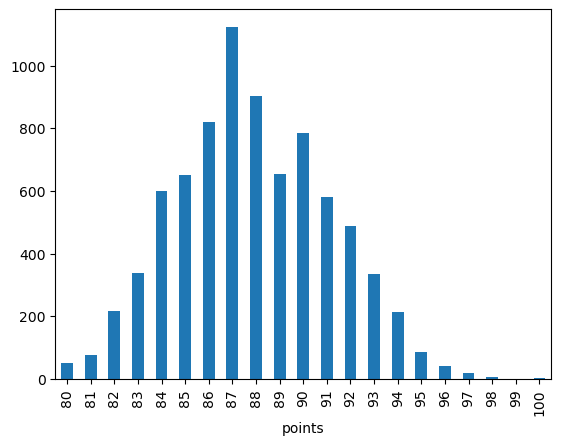

In [151]:
y1_values = y1_train.value_counts().sort_index()
y1_values.plot.bar()

As can be seen above, there is certainly more data about the wines with scores between about 85 and 91. Therefore, the model will probably be better at predicting the points of the wines that have the score arouns these values, than for example the ones with the very best points.

### Testing the model

The accuracy of a machine learning model can be tested with a mean squared error value. It measures the average squared differences between the predicted values (y1_pred) and the actual values (y1_test) in a regression problem.

A lower MSE value indicates smaller errors as well as a better predictive model.

In [152]:
mse = mean_squared_error(y1_test, y1_pred)
print('The mean squared error value of the first machine learning model is ', mse, '.')

The mean squared error value of the first machine learning model is  1.0652505957301246 .


## The second machine learning model: Predicting the score of the wine based on other charasteristics

### Data preprocessing

The second machine learning model utilizes other charasteristics of the wine, such as country, region and price, and predicts the score of the wine based on them.

The data has to be preprocessed again in a way to convert the strings into numerical values. [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) function is being used for this process.

To keep the template more simple and clear, another DataFrame df2 is created for the second machine learning model.

In [153]:
df2 = data.copy()

df2 = df2.drop('description', axis=1)

le = preprocessing.LabelEncoder()

str_columns = df2[['country', 'designation', 'price', 'province', 'region_1', 'region_2', 'variety', 'winery']]

for column in str_columns:
    value = le.fit_transform(str_columns[column])
    df2[column] = value
    
    
# chceking that the values are numerical, as wanted
df2.head()

,Unnamed: 0,country,designation,points,price,province,region_1,region_2,variety,winery
82957,82957,0,1010,84,7,122,372,18,121,2014
60768,60768,12,4904,81,15,15,718,18,195,2030
63047,63047,33,4904,93,39,243,164,3,250,342
71004,71004,6,4479,81,14,44,718,18,236,658
78169,78169,33,3566,88,32,30,464,1,195,878


Now that all the values in a datset are numeric, a learning model can be executed. For this model I have chosen a process called Random forest regression. DataFrame is first divided into two, training and testing data.

In [154]:
x2 = df2.drop(columns=['points'])
y2 = df2['points']

x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.2, random_state=42)


model2 = RandomForestRegressor(n_estimators = 100, random_state = 42)
model2.fit(x2_train, y2_train)

y2_pred = model2.predict(x2_test)


The model is tested again, and the amount of different predicted scores of the wines are also visualized in a diagram.

The average score for wines in a original dataset is 87.86 .
The average score of the predictions of the points is 87.82 .


<Axes: xlabel='points'>

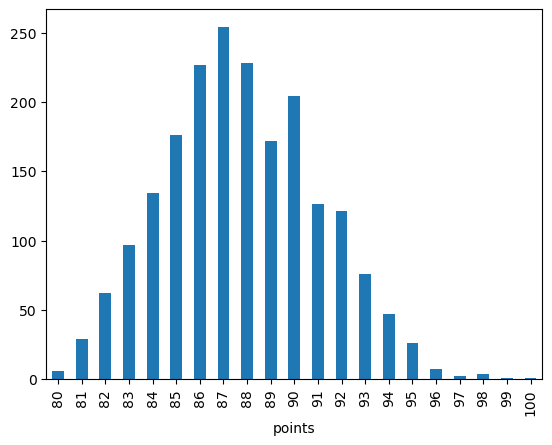

In [155]:
print('The average score for wines in a original dataset is', '{:.2f}'.format(data['points'].mean()), '.')
print('The average score of the predictions of the points is', '{:.2f}'.format(y2_pred.mean()), '.')

y1_pred_values = y1_test.value_counts().sort_index()
y1_pred_values.plot.bar()

The diagram above shows the amount of different predicted scores. The data contained more wines with points between 85 and 91, and therefore it makes sense for the frequency of the predictions to also be higher around those values. 

The accuracy of this model is also tested with the mean squared error value. 

Also, the accuracy can be tested with checking how many of the predictions were exactly correct with the original data.

In [157]:
mse = mean_squared_error(y2_test, y2_pred)

print('The mean squared error value of the second model is', mse, '.')

The mean squared error value of the second model is 5.9291222 .


In order to compare the points with the original data, the predicted points have to be rounded and converted into the same data type as in the original data. 
Rounding the values will of course make a little difference in the accuracy, but it will give an approximate idea of the amount of predictions that were correct.

In [158]:
y2_pred_rounded = np.array(np.round(y2_pred, 0)).astype(np.int64)

In [159]:
accuracy = np.sum(y2_pred_rounded == y2_test) / len(y2_test)
print("The procentage of predictions that were correct: %.2f%%" % (accuracy * 100.0), '.')

The procentage of predictions that were correct: 16.95% .


### Conclusions and comments

The mse values of the machine learning models are 1.0652505957301246 for the first model and 5.9550011 for the second one. A small mse value usually indicates small errors and therefore a good accuracy, but in order to understand the values and their meaning better, we would have to compare them to other mse values of other learning models. Next step could be, for instance, to try out different training models for the same data and see what results they give. It would also be interesting to see, what kind of results we would get with using the whole 150 000 rows of the dataset.


Even though the machine learning models may not be perfect and very accurate, this project succesfully shows different data analysis skills and techniques I have achieved during this course. The main goal of this project was to go through different stages of a data science process. Maybe the choice of the problems, the dataset or the machine learning processes could have been more succesful. Furthermore, this project is a good template for further data science tasks, since the steps can be very similar in various projects. 